In [2]:
import os

import networkx as nx
import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm, trange

In [3]:
SAVE_RES_DIR = "./matrices_viz/mimic"

if not os.path.exists(SAVE_RES_DIR):
    os.makedirs(SAVE_RES_DIR)

In [4]:
MATRICES_PATH = "./matrices_new/relevant_matrices/"
MATRICES_FILES = [el for el in os.listdir(MATRICES_PATH) if el.endswith(".csv")]
MATRICES_FILES

['bert__similarity_scores.csv',
 'bioclinical_bert.csv',
 'fisher_test.csv',
 'genes_graph_paper_2007.csv',
 'gpt_oss.csv',
 'mlm_results.csv',
 'new_cat_jacc_sorted.csv',
 'scores_DeepSeek-V3_mean.csv',
 'scores_medbert.csv',
 'scores_qwen3-235b-a22b_0.csv',
 'yandex_doc_search__scores_llm_doc.csv',
 'yandex_gpt_5__yandex_prompt_matrix.csv']

In [5]:
common_columns, common_rows = [], []
all_dfs = dict()

for m_file in tqdm(MATRICES_FILES):
    if "gene" not in m_file:
        if "fisher" in m_file:
            sep = ";"
        else:
            sep = ","
        df = pd.read_csv(os.path.join(MATRICES_PATH, m_file), sep=sep)
        if "Unnamed: 0" in df.columns:
            df = df.set_index("Unnamed: 0")
        print(m_file, df.shape)
        all_dfs[m_file] = df
        common_columns.append(df.columns.tolist())
        common_rows.append(df.index.tolist())

common_columns = set.intersection(*map(set, common_columns))
common_rows = set.intersection(*map(set, common_rows))

len(common_columns), len(common_rows)

  8%|▊         | 1/12 [00:00<00:03,  2.96it/s]

bert__similarity_scores.csv (1696, 1696)


 25%|██▌       | 3/12 [00:00<00:02,  3.94it/s]

bioclinical_bert.csv (1704, 1704)
fisher_test.csv (1704, 1704)


 42%|████▏     | 5/12 [00:01<00:01,  4.58it/s]

gpt_oss.csv (2101, 2101)


 50%|█████     | 6/12 [00:01<00:01,  3.76it/s]

mlm_results.csv (1757, 1757)


 58%|█████▊    | 7/12 [00:01<00:01,  3.56it/s]

new_cat_jacc_sorted.csv (1757, 1757)


 67%|██████▋   | 8/12 [00:02<00:01,  3.32it/s]

scores_DeepSeek-V3_mean.csv (2046, 2046)


 75%|███████▌  | 9/12 [00:02<00:00,  3.12it/s]

scores_medbert.csv (1757, 1757)


 83%|████████▎ | 10/12 [00:02<00:00,  3.31it/s]

scores_qwen3-235b-a22b_0.csv (2032, 2032)


 92%|█████████▏| 11/12 [00:03<00:00,  2.75it/s]

yandex_doc_search__scores_llm_doc.csv (1696, 1696)


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]

yandex_gpt_5__yandex_prompt_matrix.csv (1696, 1696)


(1646, 1646)

In [6]:
assert len(all_dfs) == len(MATRICES_FILES) - 1, "Probably gene-based GT is in all_dfs!!!"

In [7]:
common_icds = sorted(list(common_columns & common_rows))
len(common_icds)

1646

In [8]:
for df_name, df in tqdm(all_dfs.items()):
    df1 = deepcopy(df)
    df1 = df1[common_icds][df1.index.isin(common_icds)].reindex(common_icds)
    np.fill_diagonal(df1.values, 0)
    all_dfs[df_name] = df1

100%|██████████| 11/11 [00:00<00:00, 34.68it/s]


In [9]:
for df_name, df in tqdm(all_dfs.items()):
    print(df.shape)

100%|██████████| 11/11 [00:00<00:00, 3256.45it/s]

(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)
(1646, 1646)


In [11]:
EXPERIMENTS = {
    "Methods on real data": {
        "Fisher exact test": 'fisher_test.csv',
        "Jaccard similarity": 'new_cat_jacc_sorted.csv',
        "MLM": 'mlm_results.csv',
    },
    "Pretrained on medical domain": {
        "Med-BERT": 'scores_medbert.csv',
        "BioClinicalBERT": 'bioclinical_bert.csv',
    },
    "Text-based methods": {
        "Pretrained BERT": 'bert__similarity_scores.csv', 
        "Yandex Doc Search": 'yandex_doc_search__scores_llm_doc.csv', 
    },
    "LLMs": {
        "GPT-OSS": "gpt_oss.csv",
        "Qwen-3": 'scores_qwen3-235b-a22b_0.csv',
        "DeepSeek-v3": 'scores_DeepSeek-V3_mean.csv',
        "YandexGPT-5": 'yandex_gpt_5__yandex_prompt_matrix.csv',
    }
}

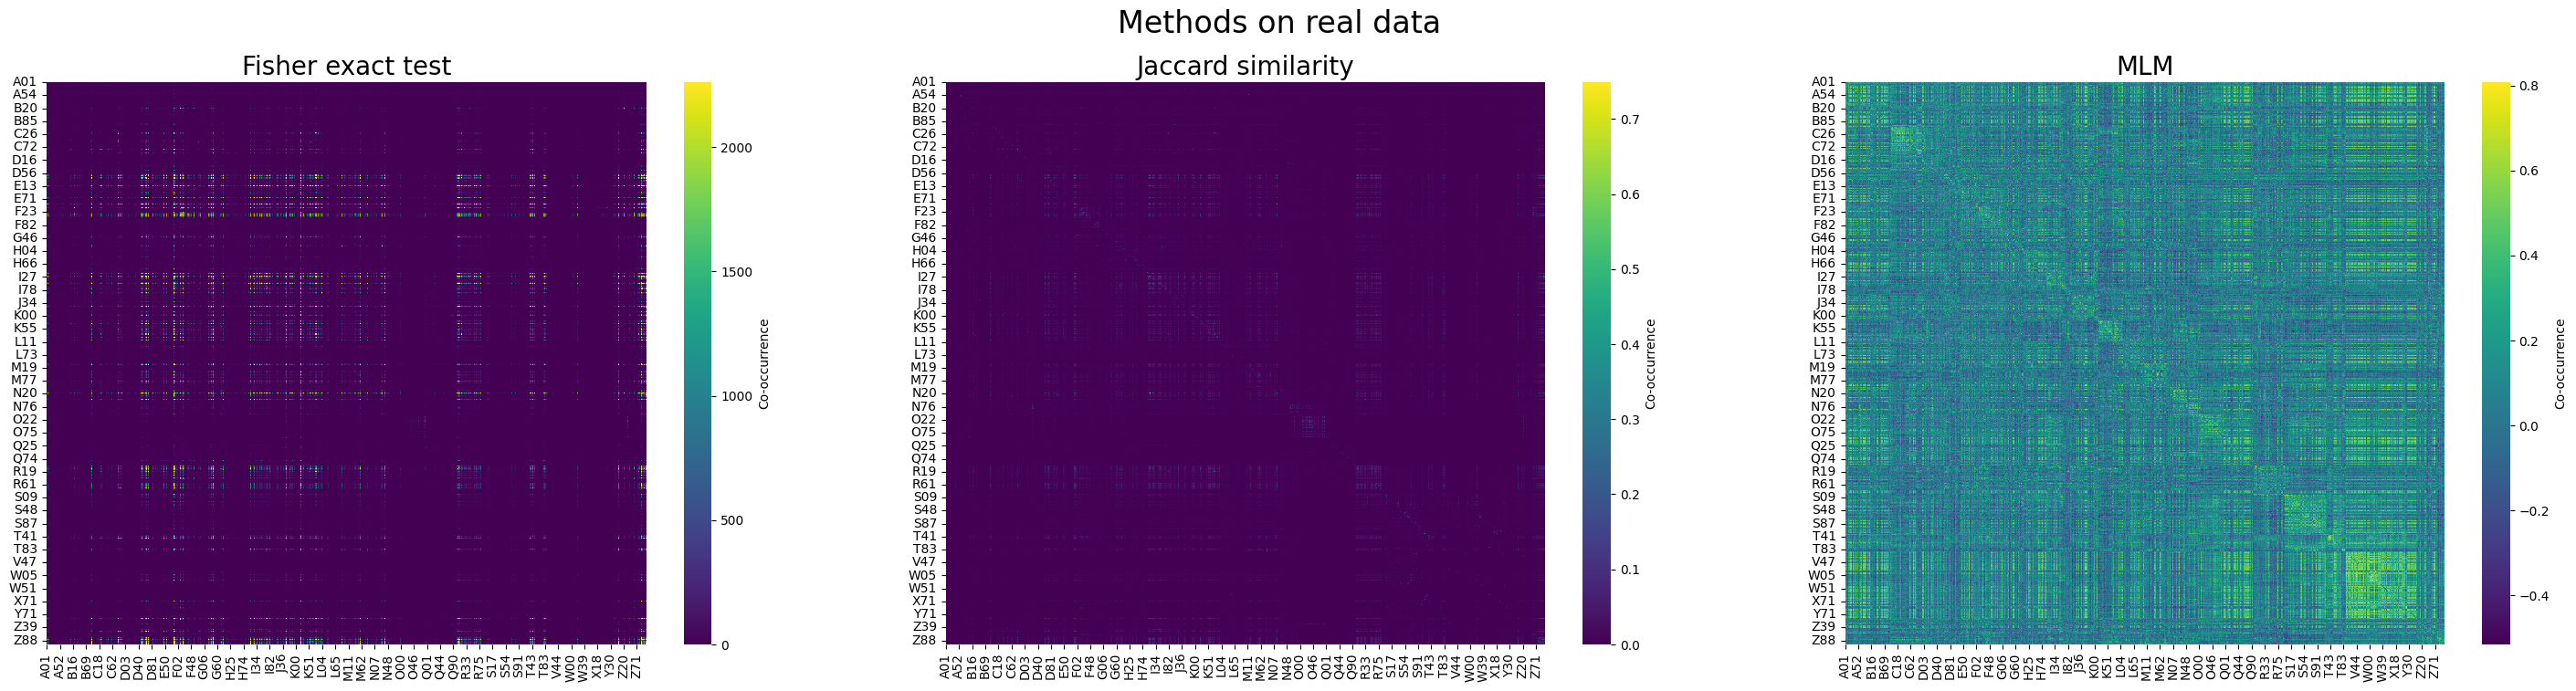

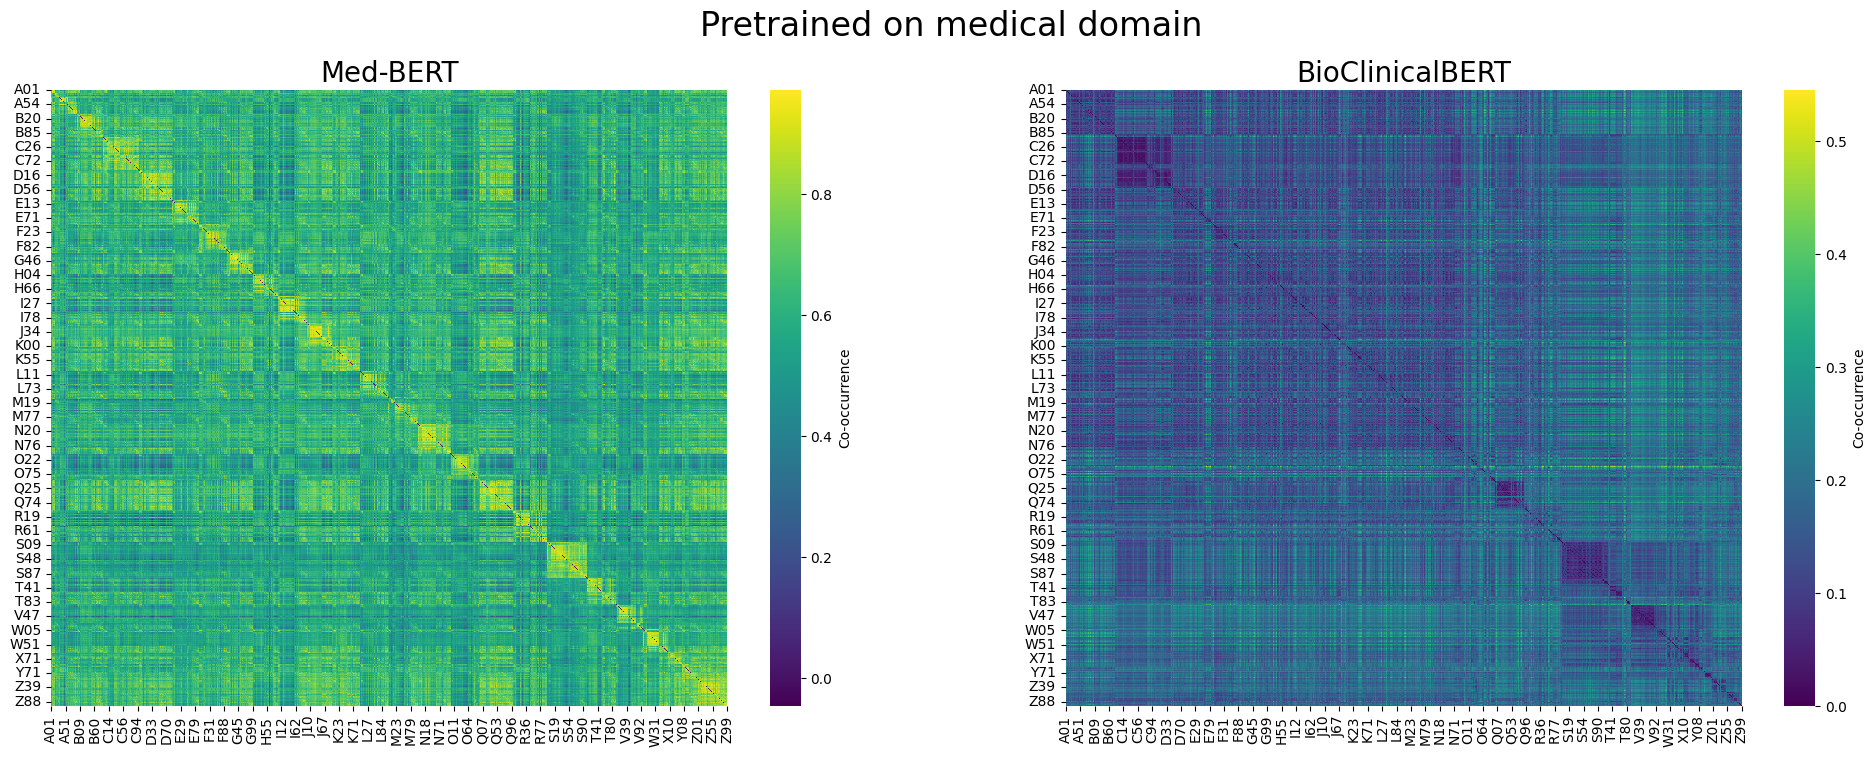

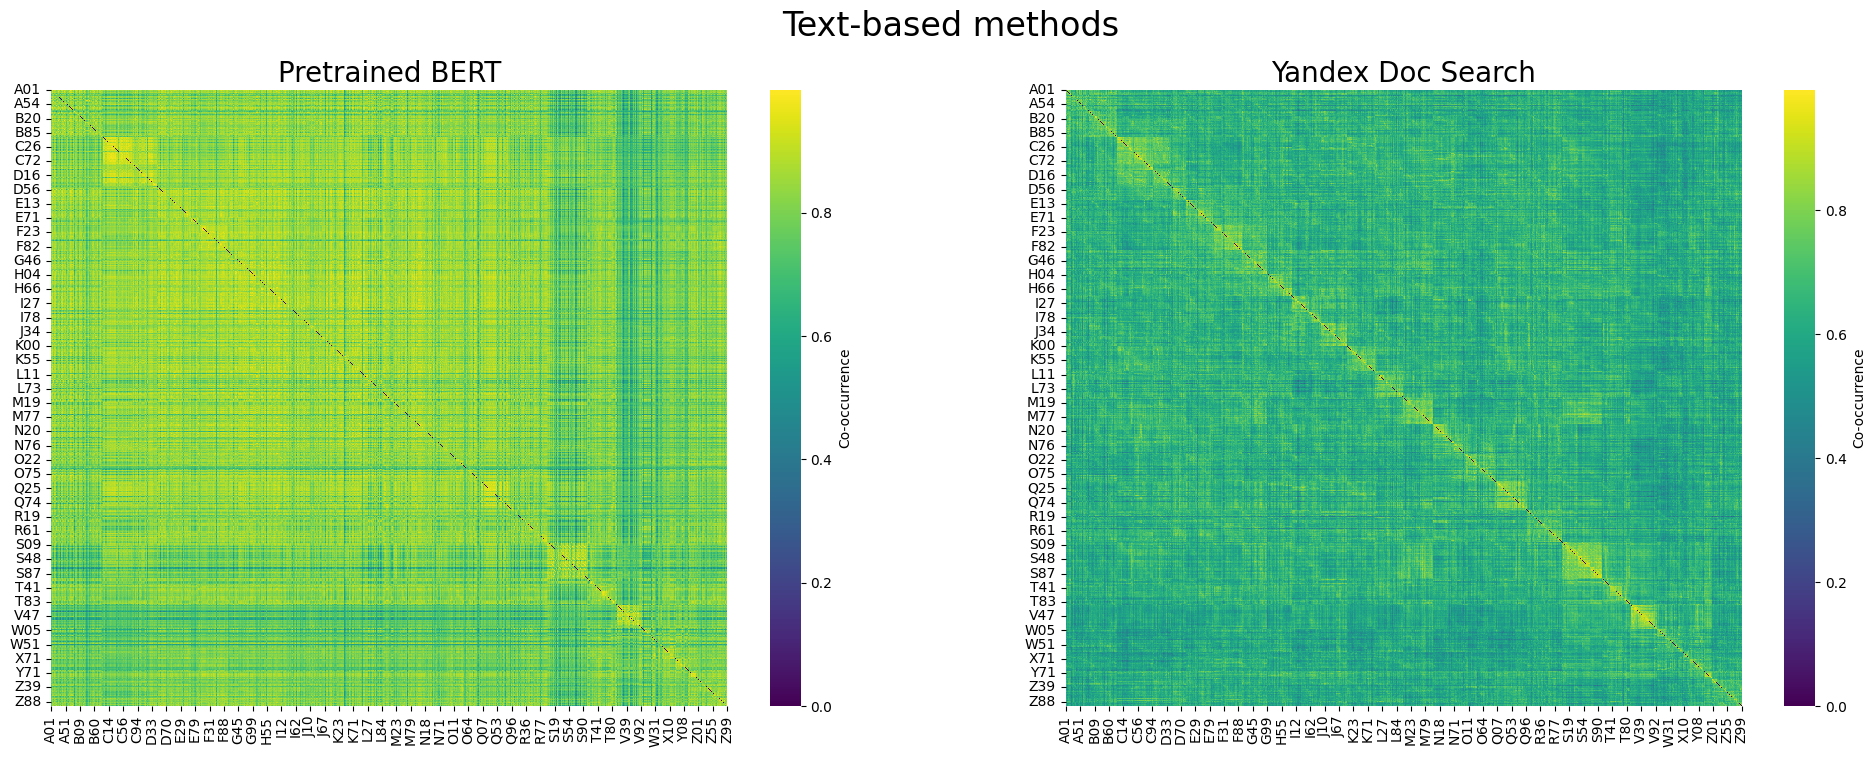

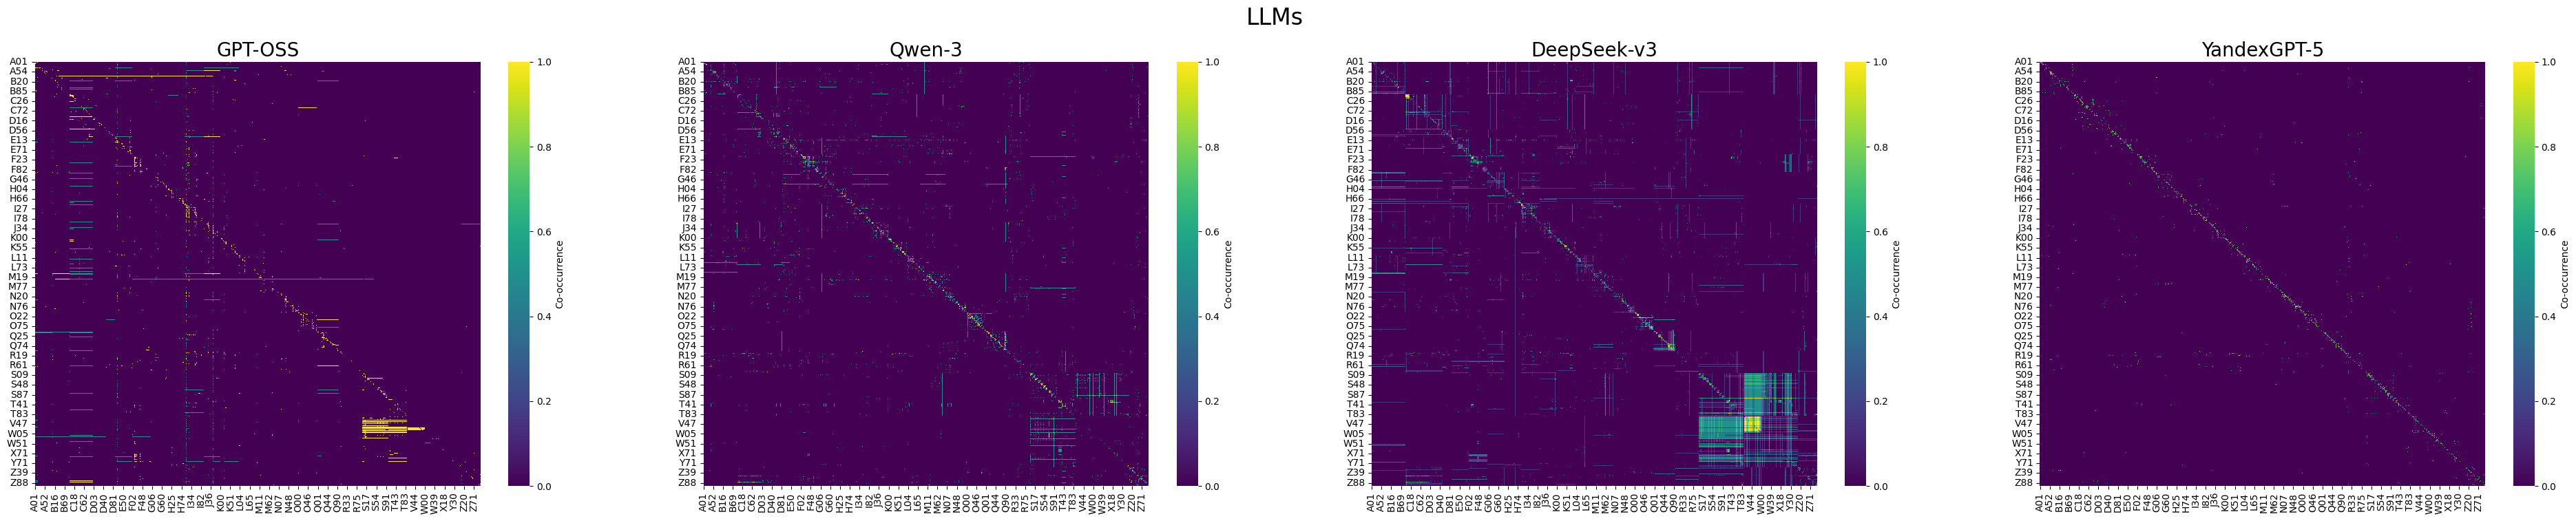

In [12]:
for exp_cat, exp_files in EXPERIMENTS.items():
    ncols = len(exp_files.values())
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12*ncols, 8))
    fig.suptitle(exp_cat, fontsize=24)
    for i, (model_name, m_file) in enumerate(exp_files.items()):
        df = all_dfs[m_file]
        if "fisher" in m_file:
            upper_bound = np.quantile(df.values.reshape(-1), 0.997) #np.quantile(df.values, 0.75)
            df[df > upper_bound] = upper_bound

        sns.heatmap(
            df,
            cmap="viridis",
            cbar_kws={"label": "Co-occurrence"},
            ax=ax[i],
        )
        ax[i].set_xlabel("");
        ax[i].set_ylabel("");
        ax[i].set_title(model_name, fontsize=20);
    plt.savefig(
        f"{SAVE_RES_DIR}/{exp_cat.lower().replace(' ', '_')}.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

# Correlation analysis

In [13]:
EXPERIMENTS_unfold = dict()
for k, v in EXPERIMENTS.items():
    for model_name, m_file in v.items():
        EXPERIMENTS_unfold[model_name] = m_file
EXPERIMENTS_unfold

{'Fisher exact test': 'fisher_test.csv',
 'Jaccard similarity': 'new_cat_jacc_sorted.csv',
 'MLM': 'mlm_results.csv',
 'Med-BERT': 'scores_medbert.csv',
 'BioClinicalBERT': 'bioclinical_bert.csv',
 'Pretrained BERT': 'bert__similarity_scores.csv',
 'Yandex Doc Search': 'yandex_doc_search__scores_llm_doc.csv',
 'GPT-OSS': 'gpt_oss.csv',
 'Qwen-3': 'scores_qwen3-235b-a22b_0.csv',
 'DeepSeek-v3': 'scores_DeepSeek-V3_mean.csv',
 'YandexGPT-5': 'yandex_gpt_5__yandex_prompt_matrix.csv'}

In [14]:
list(EXPERIMENTS_unfold.keys())

['Fisher exact test',
 'Jaccard similarity',
 'MLM',
 'Med-BERT',
 'BioClinicalBERT',
 'Pretrained BERT',
 'Yandex Doc Search',
 'GPT-OSS',
 'Qwen-3',
 'DeepSeek-v3',
 'YandexGPT-5']

In [15]:
from scipy.stats import spearmanr

In [16]:
corrs = []
for i, (model_name_i, m_file_i) in tqdm(enumerate(EXPERIMENTS_unfold.items())):
    for j, (model_name_j, m_file_j) in enumerate(EXPERIMENTS_unfold.items()):
        if model_name_i != model_name_j:
            df_i, df_j = all_dfs[m_file_i], all_dfs[m_file_j]
            corr, pval = spearmanr(
                df_i.values.flatten(),
                df_j.values.flatten(),
            )
            corrs.append(
                {
                    "model_i": model_name_i,
                    "model_j": model_name_j,
                    "corr_coef": corr,
                    "p_val": pval,

                }
            )

corrs = pd.DataFrame(corrs)
corrs

11it [01:14,  6.75s/it]


model_i             model_j  corr_coef  p_val
0    Fisher exact test  Jaccard similarity   0.772556    0.0
1    Fisher exact test                 MLM  -0.065240    0.0
2    Fisher exact test            Med-BERT   0.046482    0.0
3    Fisher exact test     BioClinicalBERT  -0.043117    0.0
4    Fisher exact test     Pretrained BERT   0.155012    0.0
..                 ...                 ...        ...    ...
105        YandexGPT-5     Pretrained BERT   0.043974    0.0
106        YandexGPT-5   Yandex Doc Search   0.083997    0.0
107        YandexGPT-5             GPT-OSS   0.082022    0.0
108        YandexGPT-5              Qwen-3   0.195370    0.0
109        YandexGPT-5         DeepSeek-v3   0.141205    0.0

[110 rows x 4 columns]

In [17]:
np.unique(corrs["p_val"])

array([0.00000000e+000, 4.64599374e-211, 8.94502655e-182, 4.92527099e-102,
       2.35307104e-058, 3.85853724e-055, 6.70887086e-042, 6.70887086e-042,
       1.64347106e-038, 6.62948320e-005])

In [18]:
corrs['model_i'] = pd.Categorical(
    corrs['model_i'], 
    categories=list(EXPERIMENTS_unfold.keys()), 
    ordered=True,
)
corrs['model_j'] = pd.Categorical(
    corrs['model_j'], 
    categories=list(EXPERIMENTS_unfold.keys()), 
    ordered=True,
)

In [19]:
corrs_matrix = corrs.pivot(index="model_i", columns="model_j", values="corr_coef").fillna(1).round(3)
corrs_matrix

model_j             Fisher exact test  Jaccard similarity    MLM  Med-BERT  \
model_i                                                                      
Fisher exact test               1.000               0.773 -0.065     0.046   
Jaccard similarity              0.773               1.000 -0.107     0.048   
MLM                            -0.065              -0.107  1.000     0.013   
Med-BERT                        0.046               0.048  0.013     1.000   
BioClinicalBERT                -0.043              -0.064 -0.019    -0.112   
Pretrained BERT                 0.155               0.180 -0.044     0.147   
Yandex Doc Search               0.080               0.113  0.052     0.179   
GPT-OSS                         0.010               0.008  0.026     0.017   
Qwen-3                          0.060               0.072  0.053     0.030   
DeepSeek-v3                    -0.002               0.010  0.125     0.026   
YandexGPT-5                     0.045               0.057  0.047     0.060   

model_j             BioClinicalBERT  Pretrained BERT  Yandex Doc Search  \
model_i                                                                   
Fisher exact test            -0.043            0.155              0.080   
Jaccard similarity           -0.064            0.180              0.113   
MLM                          -0.019           -0.044              0.052   
Med-BERT                     -0.112            0.147              0.179   
BioClinicalBERT               1.000           -0.408             -0.293   
Pretrained BERT              -0.408            1.000              0.326   
Yandex Doc Search            -0.293            0.326              1.000   
GPT-OSS                      -0.038            0.008              0.039   
Qwen-3                       -0.049            0.029              0.094   
DeepSeek-v3                  -0.074           -0.025              0.135   
YandexGPT-5                  -0.052            0.044              0.084   

model_j             GPT-OSS  Qwen-3  DeepSeek-v3  YandexGPT-5  
model_i                                                        
Fisher exact test     0.010   0.060       -0.002        0.045  
Jaccard similarity    0.008   0.072        0.010        0.057  
MLM                   0.026   0.053        0.125        0.047  
Med-BERT              0.017   0.030        0.026        0.060  
BioClinicalBERT      -0.038  -0.049       -0.074       -0.052  
Pretrained BERT       0.008   0.029       -0.025        0.044  
Yandex Doc Search     0.039   0.094        0.135        0.084  
GPT-OSS               1.000   0.103        0.121        0.082  
Qwen-3                0.103   1.000        0.237        0.195  
DeepSeek-v3           0.121   0.237        1.000        0.141  
YandexGPT-5           0.082   0.195        0.141        1.000

In [20]:
SAVE_RES_DIR

'./matrices_viz/mimic'

In [21]:
corrs_matrix.to_excel(f"{SAVE_RES_DIR}/corrs_matrix.xlsx")

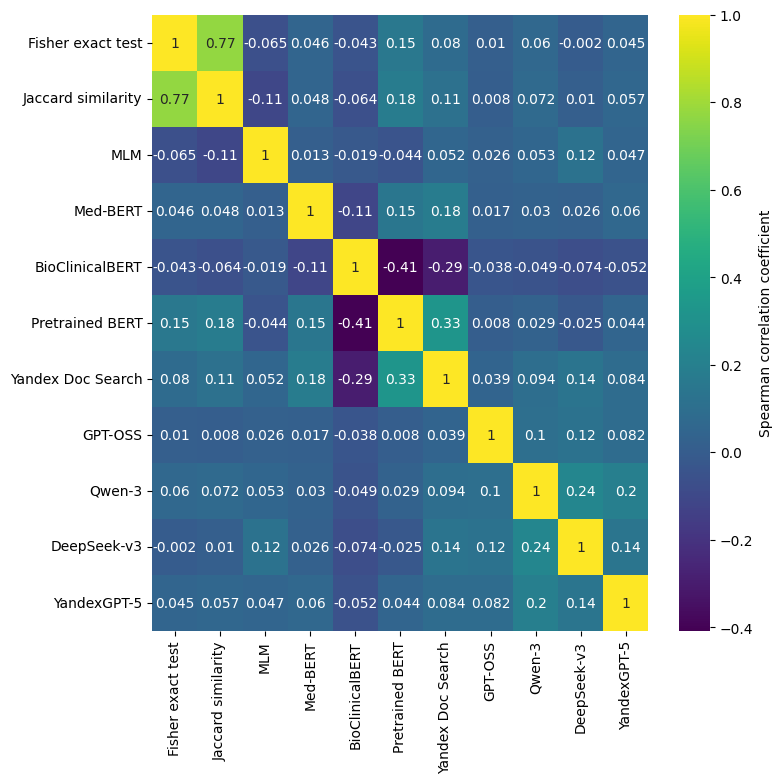

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    data=corrs_matrix,
    cmap="viridis",
    cbar_kws={"label": "Spearman correlation coefficient"},
    annot=True,
    ax=ax,
)
ax.set_xlabel("");
ax.set_ylabel("");

plt.savefig(
    f"{SAVE_RES_DIR}/spearman_corr.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [23]:
for col in corrs_matrix:
    print(
        col,
        round(corrs_matrix[col].min(), 3),
        round(corrs_matrix[col][corrs_matrix[col] != 1].max(), 3),
    )

Fisher exact test -0.065 0.773
Jaccard similarity -0.107 0.773
MLM -0.107 0.125
Med-BERT -0.112 0.179
BioClinicalBERT -0.408 -0.019
Pretrained BERT -0.408 0.326
Yandex Doc Search -0.293 0.326
GPT-OSS -0.038 0.121
Qwen-3 -0.049 0.237
DeepSeek-v3 -0.074 0.237
YandexGPT-5 -0.052 0.195
